In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import datetime
import requests
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from itertools import combinations
from collections import OrderedDict 

%matplotlib inline

## READ IN MLB STATS FOR 1876-2018 SEASONS 

## Note: No salary data is used for regression in this case.

In [2]:
# read data from csv file for 2001-2018 MLB seasons
#df = pd.read_csv('MLB_STATS_1900-2018_BP.csv')
df = pd.read_csv('MLB_STATS_1876-2018_BP.csv')

In [3]:
df.head()

,Tm,#Bat,BatAge,R/G,G_x,PA,AB,R_x,H_x,2B,...,SO_y,SO/W,SO9,SV,W,W-L%,WHIP,WP,cSho,tSho
0,ATH,21,26.0,6.30,60,2414,2387,378,646,79,...,22,0.54,0.4,2,14,0.237,1.498,33,1.0,1.0
1,BSN,17,24.7,6.73,70,2780,2722,471,723,96,...,77,0.74,1.1,7,39,0.557,1.323,46,3.0,3.0
2,CHC,11,25.9,9.45,66,2818,2748,624,926,131,...,51,1.76,0.8,4,52,0.788,1.075,3,8.0,9.0
3,CIN,13,24.5,3.66,65,2413,2372,238,555,51,...,60,1.76,0.9,0,9,0.138,1.496,28,0.0,0.0
4,HAR,12,26.3,6.22,69,2703,2664,429,711,96,...,114,4.22,1.6,0,47,0.691,0.957,15,11.0,11.0


In [4]:
df.shape

(2815, 65)

In [5]:
df.tail()

,Tm,#Bat,BatAge,R/G,G_x,PA,AB,R_x,H_x,2B,...,SO_y,SO/W,SO9,SV,W,W-L%,WHIP,WP,cSho,tSho
2810,STL,49,28.0,4.69,162,6200,5498,759,1369,248,...,1337,2.25,8.3,43,88,0.543,1.338,63,1.0,8.0
2811,TBR,54,27.1,4.42,162,6195,5475,716,1415,274,...,1421,2.84,8.8,52,90,0.556,1.199,55,0.0,14.0
2812,TEX,50,27.4,4.55,162,6163,5453,737,1308,266,...,1121,2.28,7.1,42,67,0.414,1.403,57,0.0,5.0
2813,TOR,63,28.9,4.38,162,6076,5477,709,1336,320,...,1298,2.36,8.1,39,73,0.451,1.414,71,0.0,3.0
2814,WSN,53,27.6,4.76,162,6288,5517,771,1402,284,...,1417,2.91,8.8,40,82,0.506,1.250,42,1.0,7.0


In [6]:
df.dtypes

Tm         object
#Bat        int64
BatAge    float64
R/G       float64
G_x         int64
           ...   
W-L%      float64
WHIP      float64
WP          int64
cSho      float64
tSho      float64
Length: 65, dtype: object

In [7]:
df.columns

Index(['Tm', '#Bat', 'BatAge', 'R/G', 'G_x', 'PA', 'AB', 'R_x', 'H_x', '2B',
       '3B', 'HR_x', 'RBI', 'SB', 'CS', 'BB_x', 'SO_x', 'BA', 'OBP', 'SLG',
       'OPS', 'OPS+', 'TB', 'GDP', 'HBP_x', 'SH', 'SF', 'IBB_x', 'LOB_x',
       'Year', '#P', 'BB_y', 'BB9', 'BF', 'BK', 'CG', 'ER', 'ERA', 'ERA+',
       'FIP', 'G_y', 'GF', 'GS', 'H_y', 'H9', 'HBP_y', 'HR_y', 'HR9', 'IBB_y',
       'IP', 'L', 'LOB_y', 'PAge', 'R_y', 'RA/G', 'SO_y', 'SO/W', 'SO9', 'SV',
       'W', 'W-L%', 'WHIP', 'WP', 'cSho', 'tSho'],
      dtype='object')

In [8]:
df.Year.value_counts()

1884    33
2017    30
2015    30
1998    30
2002    30
        ..
1879     8
1880     8
1876     8
1877     6
1878     6
Name: Year, Length: 142, dtype: int64

## Find missing values in the data

In [9]:
df.isnull().sum()

Tm        0
#Bat      0
BatAge    0
R/G       0
G_x       0
         ..
W-L%      0
WHIP      0
WP        0
cSho      8
tSho      8
Length: 65, dtype: int64

In [10]:
#df[df.isnull() == True].columns
df.columns[df.isnull().any()].tolist()

['RBI',
 'SB',
 'CS',
 'GDP',
 'HBP_x',
 'SH',
 'SF',
 'IBB_x',
 'LOB_x',
 'HBP_y',
 'IBB_y',
 'LOB_y',
 'cSho',
 'tSho']

In [11]:
correlation = df.corr()

## Study Correlation Of Features With Wins.

In [12]:
W_corr = correlation.W
W_corr

#Bat      0.178940
BatAge    0.352487
R/G       0.224332
G_x       0.582830
PA        0.629993
            ...   
W-L%      0.819723
WHIP     -0.336374
WP       -0.107353
cSho      0.272929
tSho      0.508369
Name: W, Length: 64, dtype: float64

In [13]:
type(W_corr)

pandas.core.series.Series

In [14]:
W_corr.sort_values(ascending=True)[:20]

RA/G    -0.607445
H9      -0.487337
WHIP    -0.336374
L       -0.332367
ERA     -0.242158
CG      -0.175771
R_y     -0.162247
WP      -0.107353
HBP_y   -0.092135
IBB_y   -0.050684
FIP     -0.025223
SH      -0.018893
CS      -0.016638
SB      -0.008447
3B       0.014362
BB9      0.037164
LOB_y    0.042761
GDP      0.077197
ER       0.081558
BK       0.119359
Name: W, dtype: float64

In [15]:
W_corr.sort_values(ascending=False)[:40]

W         1.000000
W-L%      0.819723
TB        0.649951
H_x       0.649828
RBI       0.648062
PA        0.629993
R_x       0.626056
IP        0.612138
AB        0.599076
BB_x      0.586737
G_y       0.582832
G_x       0.582830
GS        0.582657
OPS       0.564913
ERA+      0.563912
OPS+      0.549647
OBP       0.533598
SLG       0.521056
2B        0.509120
tSho      0.508369
BF        0.503418
SV        0.482644
HR_x      0.447111
SO_y      0.441019
PAge      0.390851
LOB_x     0.359822
GF        0.356504
IBB_x     0.354443
SF        0.354130
BA        0.353061
Year      0.352521
BatAge    0.352487
SO9       0.334545
SO_x      0.304754
cSho      0.272929
HR_y      0.256221
H_y       0.240439
BB_y      0.237272
R/G       0.224332
HR9       0.207969
Name: W, dtype: float64

## Examine the data for Null values.

In [16]:
#df.SV.isna().sum()
df.isnull().sum()

Tm        0
#Bat      0
BatAge    0
R/G       0
G_x       0
         ..
W-L%      0
WHIP      0
WP        0
cSho      8
tSho      8
Length: 65, dtype: int64

In [17]:
df.columns

Index(['Tm', '#Bat', 'BatAge', 'R/G', 'G_x', 'PA', 'AB', 'R_x', 'H_x', '2B',
       '3B', 'HR_x', 'RBI', 'SB', 'CS', 'BB_x', 'SO_x', 'BA', 'OBP', 'SLG',
       'OPS', 'OPS+', 'TB', 'GDP', 'HBP_x', 'SH', 'SF', 'IBB_x', 'LOB_x',
       'Year', '#P', 'BB_y', 'BB9', 'BF', 'BK', 'CG', 'ER', 'ERA', 'ERA+',
       'FIP', 'G_y', 'GF', 'GS', 'H_y', 'H9', 'HBP_y', 'HR_y', 'HR9', 'IBB_y',
       'IP', 'L', 'LOB_y', 'PAge', 'R_y', 'RA/G', 'SO_y', 'SO/W', 'SO9', 'SV',
       'W', 'W-L%', 'WHIP', 'WP', 'cSho', 'tSho'],
      dtype='object')

## Exploratory Data Analysis

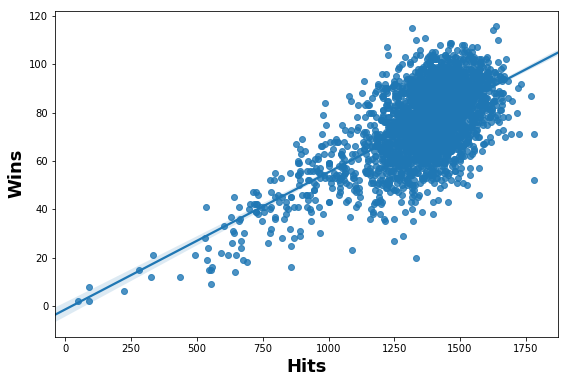

In [18]:
plt.figure(figsize = [9,6]) # [width, height]
#plt.title('MLB 1876-2018',weight = 'bold', size =20)
sns.regplot(x="H_x", y="W", data = df)
plt.xlabel('Hits', weight = 'bold',size =18)
plt.ylabel('Wins', weight = 'bold', size=18)
plt.savefig('MLB_W_Hits.png')

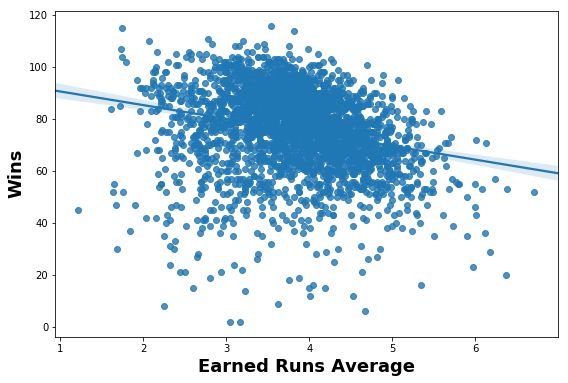

In [19]:
plt.figure(figsize = [9,6]) # [width, height]
#plt.title('MLB 1876-2018',weight = 'bold', size =20)
sns.regplot(x="ERA", y="W", data = df)
plt.xlabel('Earned Runs Average', weight = 'bold',size =18)
plt.ylabel('Wins', weight = 'bold', size=18)
plt.savefig('MLB_W_ERA.png')

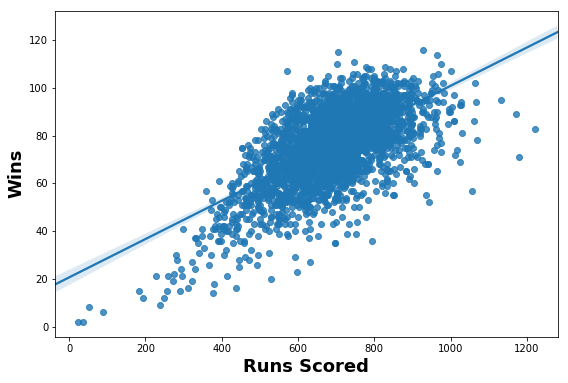

In [20]:
plt.figure(figsize = [9,6]) # [width, height]
#plt.title('MLB 1876-2018',weight = 'bold', size =20)
sns.regplot(x="R_x", y="W", data = df)
plt.xlabel('Runs Scored', weight = 'bold',size =18)
plt.ylabel('Wins', weight = 'bold', size=18)
plt.savefig('MLB_W_Runs.png')

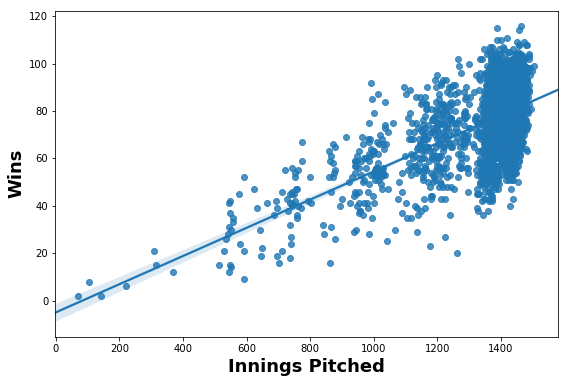

In [21]:
plt.figure(figsize = [9,6]) # [width, height]
#plt.title('MLB 1876-2018',weight = 'bold', size =20)
sns.regplot(x="IP", y="W", data = df)
plt.xlabel('Innings Pitched', weight = 'bold',size =18)
plt.ylabel('Wins', weight = 'bold', size=18)
#plt.savefig('MLB_W_Runs.png')

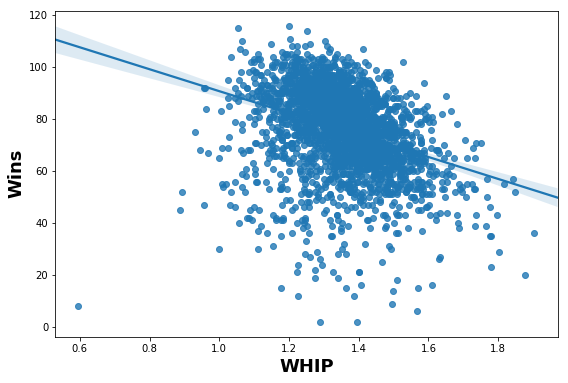

In [22]:
plt.figure(figsize = [9,6]) # [width, height]
#plt.title('MLB 1876-2018',weight = 'bold', size =20)
sns.regplot(x="WHIP", y="W", data = df)
plt.xlabel('WHIP', weight = 'bold',size =18)
plt.ylabel('Wins', weight = 'bold', size=18)
#plt.savefig('MLB_W_ERA.png')

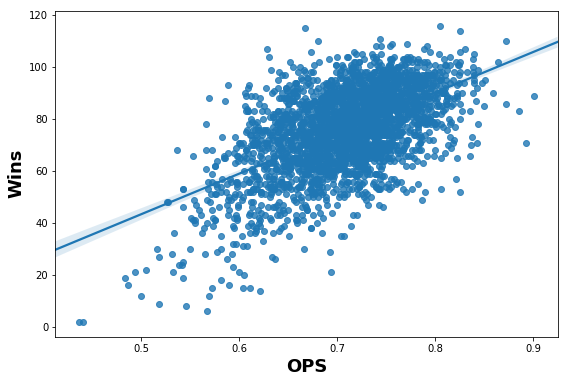

In [23]:
plt.figure(figsize = [9,6]) # [width, height]
#plt.title('MLB 1876-2018',weight = 'bold', size =20)
sns.regplot(x="OPS", y="W", data = df)
plt.xlabel('OPS', weight = 'bold',size =18)
plt.ylabel('Wins', weight = 'bold', size=18)
#plt.savefig('MLB_W_ERA.png')

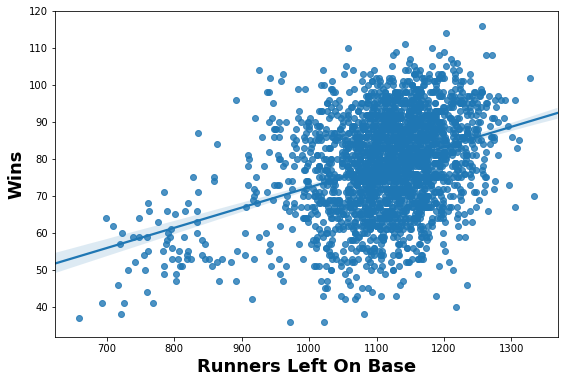

In [24]:
plt.figure(figsize = [9,6]) # [width, height]
#plt.title('MLB 1876-2018',weight = 'bold', size =20)
sns.regplot(x="LOB_x", y="W", data = df)
plt.xlabel('Runners Left On Base', weight = 'bold',size =18)
plt.ylabel('Wins', weight = 'bold', size=18)
#plt.savefig('MLB_W_ERA.png')

## No surprise. Wins are positively correlated with runs, and hits. But, wins are negatively correlated with Earned Run Average (ERA).

In [25]:
predictors = ['W','#Bat','BatAge','G_x','PA','AB', 'R_x','H_x','2B','HR_x']
 
df_1 = df[predictors]

## Heatmaps: Correlation of Features with Wins

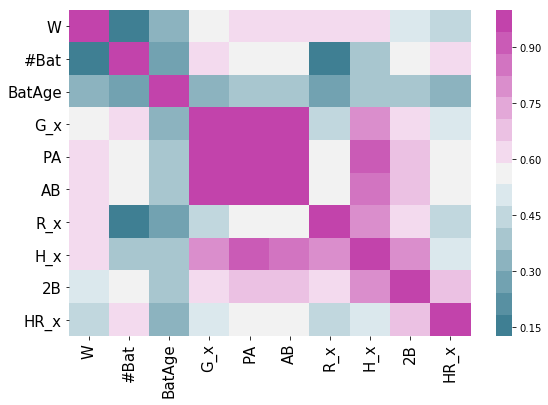

In [26]:
%matplotlib inline 
corr = df_1.corr()
plt.figure(figsize = [9,6]) 
plt.tick_params(labelsize=15)
sns.heatmap(corr, cmap= sns.diverging_palette(220, 320, n=15),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.savefig('MLB_W_hmap_1.png')

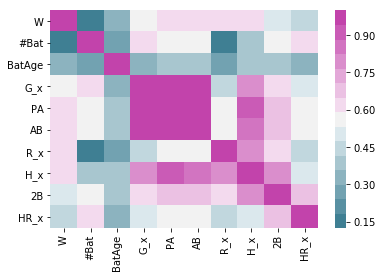

In [27]:
sns.heatmap(corr, cmap= sns.diverging_palette(220,320, n=15),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [28]:
corr

,W,#Bat,BatAge,G_x,PA,AB,R_x,H_x,2B,HR_x
W,1.000000,0.178940,0.352487,0.582830,0.629993,0.599076,0.626056,0.649828,0.509120,0.447111
#Bat,0.178940,1.000000,0.258566,0.595320,0.579680,0.577388,0.126389,0.406306,0.548037,0.648376
BatAge,0.352487,0.258566,1.000000,0.356100,0.390164,0.368613,0.286743,0.395255,0.374820,0.319800
G_x,0.582830,0.595320,0.356100,1.000000,0.979475,0.979470,0.428928,0.806721,0.611673,0.517051
PA,0.629993,0.579680,0.390164,0.979475,1.000000,0.990543,0.562848,0.883688,0.690704,0.564084
AB,0.599076,0.577388,0.368613,0.979470,0.990543,1.000000,0.541059,0.882526,0.688636,0.560683
R_x,0.626056,0.126389,0.286743,0.428928,0.562848,0.541059,1.000000,0.771996,0.644847,0.465963
H_x,0.649828,0.406306,0.395255,0.806721,0.883688,0.882526,0.771996,1.000000,0.779155,0.497800
2B,0.509120,0.548037,0.374820,0.611673,0.690704,0.688636,0.644847,0.779155,1.000000,0.651040
HR_x,0.447111,0.648376,0.319800,0.517051,0.564084,0.560683,0.465963,0.497800,0.651040,1.000000


In [29]:
predictors2 = ['W','BB_x','SO_x','OPS+','TB','#P','BB_y','BF','BK','CG','ER']

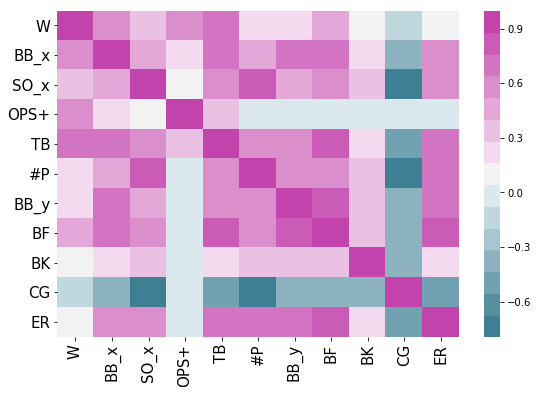

In [30]:
df_2 = df[predictors2]

%matplotlib inline
plt.figure(figsize = [9,6]) 
#plt.fontweight = 'bold'
plt.tick_params(labelsize=15)
corr = df_2.corr()
sns.heatmap(corr,cmap= sns.diverging_palette(220,320, n=15),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.savefig('MLB_W_hmap_2.png')
#plt.xlabel(fontweight='bold')
#plt.ylabel(fontweight='bold')


In [31]:
corr

,W,BB_x,SO_x,OPS+,TB,#P,BB_y,BF,BK,CG,ER
W,1.000000,0.586737,0.304754,0.549647,0.649951,0.186490,0.237272,0.503418,0.119359,-0.175771,0.081558
BB_x,0.586737,1.000000,0.440274,0.248150,0.705919,0.439710,0.705966,0.743384,0.220830,-0.370608,0.584361
SO_x,0.304754,0.440274,1.000000,0.056484,0.585641,0.790572,0.453307,0.585642,0.359676,-0.793676,0.522401
OPS+,0.549647,0.248150,0.056484,1.000000,0.398879,0.032084,-0.063885,0.014208,-0.001655,-0.068183,-0.060745
TB,0.649951,0.705919,0.585641,0.398879,1.000000,0.596112,0.626474,0.814244,0.246684,-0.540403,0.744733
#P,0.186490,0.439710,0.790572,0.032084,0.596112,1.000000,0.533250,0.577948,0.289605,-0.761983,0.652916
BB_y,0.237272,0.705966,0.453307,-0.063885,0.626474,0.533250,1.000000,0.796946,0.289484,-0.412511,0.754849
BF,0.503418,0.743384,0.585642,0.014208,0.814244,0.577948,0.796946,1.000000,0.304104,-0.421632,0.769069
BK,0.119359,0.220830,0.359676,-0.001655,0.246684,0.289605,0.289484,0.304104,1.000000,-0.427603,0.257798
CG,-0.175771,-0.370608,-0.793676,-0.068183,-0.540403,-0.761983,-0.412511,-0.421632,-0.427603,1.000000,-0.539682


In [32]:
#predictors3 = ['W','G_y','GF','H_y','HR_y', 'IP','PAge','R_y','SO_y','SV','WP']
predictors3 = ['W','G_y','GF','H_y','HR_y'] # 'IP','PAge','R_y','SO_y','SV','WP']

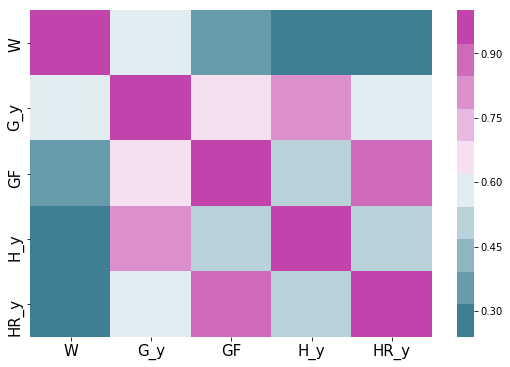

In [33]:
df_3 = df[predictors3]

%matplotlib inline
corr = df_3.corr()
plt.figure(figsize = [9,6])
plt.tick_params(labelsize=15)
#plt.fontweight = 'bold'
sns.heatmap(corr, cmap= sns.diverging_palette(220,320, n=10),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.savefig('MLB_W_hmap_3.png')

In [34]:
corr

,W,G_y,GF,H_y,HR_y
W,1.000000,0.582832,0.356504,0.240439,0.256221
G_y,0.582832,1.000000,0.662325,0.793013,0.544427
GF,0.356504,0.662325,1.000000,0.537719,0.875192
H_y,0.240439,0.793013,0.537719,1.000000,0.523020
HR_y,0.256221,0.544427,0.875192,0.523020,1.000000


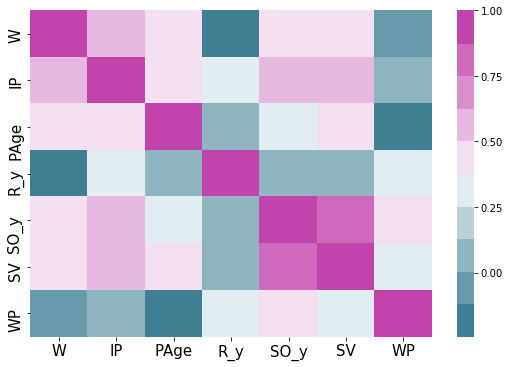

In [35]:
predictors3a = ['W','IP','PAge','R_y','SO_y','SV','WP']
df_3a = df[predictors3a]

%matplotlib inline
corr = df_3a.corr()
plt.figure(figsize = [9,6])
plt.tick_params(labelsize=15)
plt.fontweight = 'bold'
sns.heatmap(corr, cmap= sns.diverging_palette(220,320, n=10),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.savefig('MLB_W_hmap_4.png')

In [36]:
corr

,W,IP,PAge,R_y,SO_y,SV,WP
W,1.000000,0.612138,0.390851,-0.162247,0.441019,0.482644,-0.107353
IP,0.612138,1.000000,0.455137,0.358624,0.603618,0.560337,0.031811
PAge,0.390851,0.455137,1.000000,0.063881,0.290143,0.385665,-0.244377
R_y,-0.162247,0.358624,0.063881,1.000000,0.114587,0.104954,0.280456
SO_y,0.441019,0.603618,0.290143,0.114587,1.000000,0.829975,0.431844
SV,0.482644,0.560337,0.385665,0.104954,0.829975,1.000000,0.278116
WP,-0.107353,0.031811,-0.244377,0.280456,0.431844,0.278116,1.000000


In [37]:
predictors4 = ['W','R_x','BA','H_x','SV','ERA']

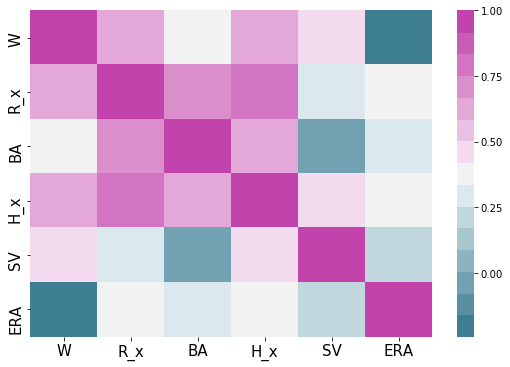

In [38]:
df_4 = df[predictors4]

%matplotlib inline
corr = df_4.corr()
plt.figure(figsize = [9,6])
plt.tick_params(labelsize=15)
sns.heatmap(corr,cmap= sns.diverging_palette(220,320, n=15),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.savefig('MLB_W_hmap_5.png')

In [39]:
corr

,W,R_x,BA,H_x,SV,ERA
W,1.000000,0.626056,0.353061,0.649828,0.482644,-0.242158
R_x,0.626056,1.000000,0.703117,0.771996,0.261525,0.366013
BA,0.353061,0.703117,1.000000,0.599693,-0.039140,0.262993
H_x,0.649828,0.771996,0.599693,1.000000,0.424374,0.387276
SV,0.482644,0.261525,-0.039140,0.424374,1.000000,0.245143
ERA,-0.242158,0.366013,0.262993,0.387276,0.245143,1.000000


In [40]:
df_4.describe()

,W,R_x,BA,H_x,SV,ERA
count,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000
mean,75.858970,687.988277,0.261003,1361.430906,24.499822,3.819663
std,16.007805,124.826282,0.017170,183.360852,16.181625,0.737716
min,2.000000,24.000000,0.175000,49.000000,0.000000,1.220000
25%,67.000000,618.000000,0.250000,1308.000000,10.000000,3.360000
50%,77.000000,691.000000,0.260000,1395.000000,25.000000,3.820000
75%,87.000000,763.000000,0.271000,1465.500000,38.000000,4.295000
max,116.000000,1220.000000,0.350000,1783.000000,68.000000,6.710000


In [41]:
corr

,W,R_x,BA,H_x,SV,ERA
W,1.000000,0.626056,0.353061,0.649828,0.482644,-0.242158
R_x,0.626056,1.000000,0.703117,0.771996,0.261525,0.366013
BA,0.353061,0.703117,1.000000,0.599693,-0.039140,0.262993
H_x,0.649828,0.771996,0.599693,1.000000,0.424374,0.387276
SV,0.482644,0.261525,-0.039140,0.424374,1.000000,0.245143
ERA,-0.242158,0.366013,0.262993,0.387276,0.245143,1.000000


In [42]:
df.columns

Index(['Tm', '#Bat', 'BatAge', 'R/G', 'G_x', 'PA', 'AB', 'R_x', 'H_x', '2B',
       '3B', 'HR_x', 'RBI', 'SB', 'CS', 'BB_x', 'SO_x', 'BA', 'OBP', 'SLG',
       'OPS', 'OPS+', 'TB', 'GDP', 'HBP_x', 'SH', 'SF', 'IBB_x', 'LOB_x',
       'Year', '#P', 'BB_y', 'BB9', 'BF', 'BK', 'CG', 'ER', 'ERA', 'ERA+',
       'FIP', 'G_y', 'GF', 'GS', 'H_y', 'H9', 'HBP_y', 'HR_y', 'HR9', 'IBB_y',
       'IP', 'L', 'LOB_y', 'PAge', 'R_y', 'RA/G', 'SO_y', 'SO/W', 'SO9', 'SV',
       'W', 'W-L%', 'WHIP', 'WP', 'cSho', 'tSho'],
      dtype='object')

In [43]:
df_fil = df.dropna()
df_fil.shape

(1618, 65)

In [44]:
features3 = ['W','PA', 'R_x', '2B','LOB_x','BB_y', 'BF', 'CG','H_y']

features4 = ['W','H9','HR_y','IP', 'LOB_y', 'SO_y', 'SV','WHIP','RA/G']

data3 = df_fil[features3]
data4 = df_fil[features4]

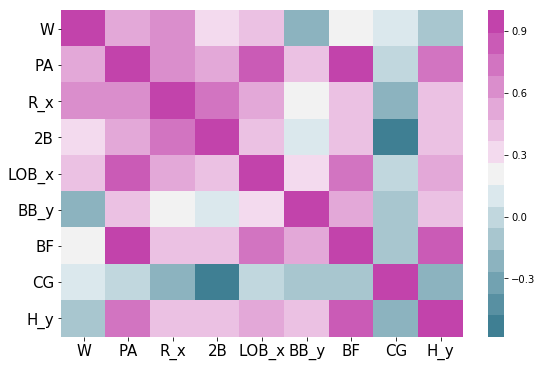

In [45]:
plt.figure(figsize = [9,6]) 
#plt.fontweight = 'bold'
plt.tick_params(labelsize=15)
corr = data3.corr()
sns.heatmap(corr,cmap= sns.diverging_palette(220,320, n=15),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
#plt.savefig('MLB_W_hmap_6.png')

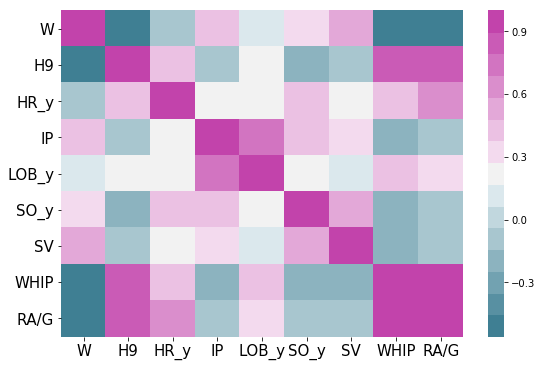

In [46]:
plt.figure(figsize = [9,6]) 
#plt.fontweight = 'bold'
plt.tick_params(labelsize=15)
corr = data4.corr()
sns.heatmap(corr,cmap= sns.diverging_palette(220,320, n=15),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
#plt.savefig('MLB_W_hmap_7.png')

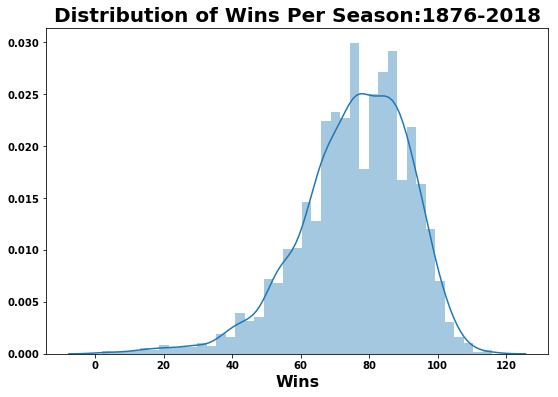

In [47]:
plt.figure(figsize = [9,6])
sns.distplot(df.W)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
plt.xlabel('Wins', weight = 'bold',size =16)
plt.title("Distribution of Wins Per Season:1876-2018",weight = 'bold',size =20)
plt.savefig('MLB_W_distribution.png')